In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [24]:
# Data Loading and Feature Engineering
data = yf.download('SOL-USD', start='2022-01-01')

data['EMA'] = data['Close'].ewm(span=7, adjust=False).mean()
data['STD'] = data['Close'].rolling(window=7).std()
data['MA7'] = data['Close'].rolling(window=7).mean()  # 7-day Moving Average
data['MA21'] = data['Close'].rolling(window=21).mean() # 21-day Moving Average

[*********************100%***********************]  1 of 1 completed


In [25]:
data = data.dropna()

features = ['Close', 'EMA', 'STD', 'MA7', 'MA21']  # Include new features
dataset = data[features].values

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [26]:
# Dataset Creation (as before)
look_back = 21  # You can adjust look_back as needed
def create_dataset(data, look_back=7):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])
        y.append(data[i, 0])  # Target is still 'Close'
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, look_back=look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

In [27]:
# Model Building (you might want to experiment with the architecture)
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=50, batch_size=32)  # Adjust epochs and batch size

Epoch 1/50


/opt/anaconda3/envs/deeplearning-env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0272
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
Epoch 13/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 14/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
Epoch 15/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 16/50
35/

In [36]:
# Prediction Loop (same logic as before, but using the updated scaled_data)
n_predictions = 7
predictions = []
for i in range(n_predictions):
    last_lookback_days = scaled_data[-look_back:]
    X_pred = np.array([last_lookback_days])
    X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], X_pred.shape[2]))
    predicted_data_scaled = model.predict(X_pred)

    dummy_data = np.zeros((1, dataset.shape[1]))
    dummy_data[0, 0] = predicted_data_scaled[0, 0]
    predicted_price_full = scaler.inverse_transform(dummy_data)
    predicted_price = predicted_price_full[0, 0]
    predictions.append(predicted_price)

    dummy_row_scaled = np.zeros((1, scaled_data.shape[1]))
    dummy_row_scaled[0, 0] = predicted_data_scaled[0, 0]
    scaled_data = np.concatenate((scaled_data, dummy_row_scaled), axis=0)

    data_extended = pd.DataFrame(scaler.inverse_transform(scaled_data), columns=features)
    data_extended['EMA'] = data_extended['Close'].ewm(span=7, adjust=False).mean()
    data_extended['STD'] = data_extended['Close'].rolling(window=7).std()
    data_extended['MA7'] = data_extended['Close'].rolling(window=7).mean()
    data_extended['MA21'] = data_extended['Close'].rolling(window=21).mean()
    data_extended = data_extended.dropna()
    scaled_data = scaler.fit_transform(data_extended[features].values)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/var/folders/cj/7jh5n4rs0_1c0m8b3059wx000000gn/T/ipykernel_78555/4049043683.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(x, y, f'{float(y):.2f}', ha='center', va='bottom', fontsize=8)


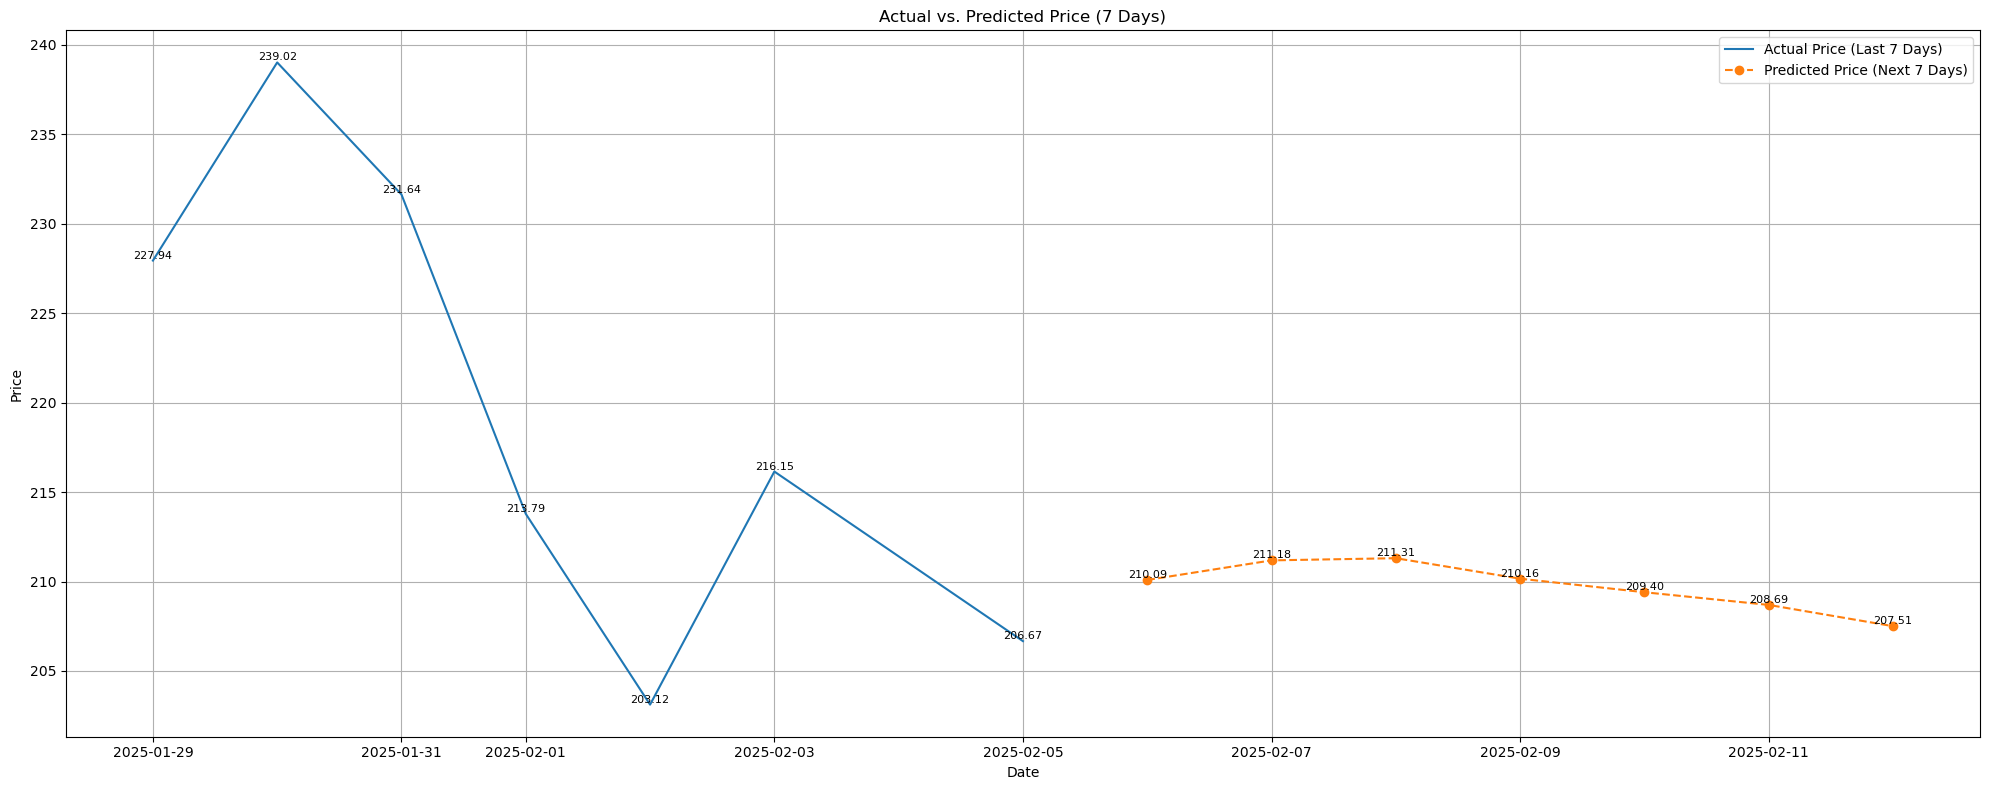

Predicted Price for 2025-02-06 00:00:00: 210.08934870220898
Predicted Price for 2025-02-07 00:00:00: 211.18386768421803
Predicted Price for 2025-02-08 00:00:00: 211.30548758593565
Predicted Price for 2025-02-09 00:00:00: 210.15964470473452
Predicted Price for 2025-02-10 00:00:00: 209.40253450815814
Predicted Price for 2025-02-11 00:00:00: 208.69368140484673
Predicted Price for 2025-02-12 00:00:00: 207.5050686076522


In [38]:
# Plotting
plt.figure(figsize=(20, 8))  # Increased figure size for better visualization

# Plot the last 7 actual prices
last_7_days = data['Close'].tail(7)
plt.plot(last_7_days.index, last_7_days.values, label='Actual Price (Last 7 Days)')

# Plot the predicted prices
future_dates = pd.date_range(start=last_7_days.index[-1] + pd.Timedelta(days=1), periods=n_predictions)
plt.plot(future_dates, predictions, label='Predicted Price (Next 7 Days)', marker='o', linestyle='--')

# Add data labels to actual prices
for x, y in zip(last_7_days.index, last_7_days.values): 
    plt.text(x, y, f'{float(y):.2f}', ha='center', va='bottom', fontsize=8) 

# Add data labels to predicted prices
for x, y in zip(future_dates, predictions):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Price (7 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the predictions with dates
for i in range(n_predictions):
    print(f"Predicted Price for {future_dates[i]}: {predictions[i]}")

In [39]:
model.save('sol_price_prediction_model.h5') 